In [37]:
import os, sys
import torch
from torch.utils.data import Dataset
from torchvision import transforms as T
from pathlib import Path
import PIL
import pandas as pd
from random import choice
from ldm.data.pose_utils import PoseVisualizer
from abc import abstractmethod
import pickle
from sklearn.model_selection import train_test_split
import numpy as np
from einops import rearrange
from glob import glob
import random
from PIL import Image
import json
import matplotlib.pyplot as plt

In [38]:
class Loader(Dataset):
    def __init__(self, folder, shuffle=False):
        super().__init__()
        self.shuffle = shuffle

    '''
    def __len__(self):
        return len(self.df)
    '''
    def random_sample(self):
        return self.__getitem__(randint(0, self.__len__() - 1))

    def sequential_sample(self, ind):
        if ind >= self.__len__() - 1:
            return self.__getitem__(0)
        return self.__getitem__(ind + 1)

    def skip_sample(self, ind):
        if self.shuffle:
            return self.random_sample()
        return self.sequential_sample(ind=ind)

    @abstractmethod
    def __getitem__(self, ind):
        pass

In [55]:
label_dict={
    0: 'background',
    1: 'top',
    2: 'outer',
    3: 'skirt',
    4: 'dress',
    5: 'pants',
    6: 'leggings',
    7: 'headwear',
    8: 'eyeglass',
    9: 'neckwear',
    10: 'belt',
    11: 'footwear',
    12: 'bag',
    13: 'hair',
    14: 'face',
    15: 'skin',
    16: 'ring',
    17: 'wrist wearing',
    18: 'socks',
    19: 'gloves',
    20: 'necklace',
    21: 'rompers',
    22: 'earrings',
    23: 'tie'}

In [64]:
label2id = dict(zip(label_dict.values(), label_dict.keys()))

In [53]:
[,
 'headwear',
 'eyeglass',
 'neckwear',
 'belt',
 
 'bag',
 'skin',
 'ring',
 'wrist wearing',
  'gloves',
 'necklace',
 'rompers',
 'earrings',
 'tie']

['background',
 'top',
 'outer',
 'skirt',
 'dress',
 'pants',
 'leggings',
 'headwear',
 'eyeglass',
 'neckwear',
 'belt',
 'footwear',
 'bag',
 'hair',
 'face',
 'skin',
 'ring',
 'wrist wearing',
 'socks',
 'gloves',
 'necklace',
 'rompers',
 'earrings',
 'tie']

In [80]:
segm_groups = [
    ['background'],
    [ 'hair','face','headwear'],
    [ 'top','outer','rompers'],
    ['skirt','dress','leggings','pants'],
    ['footwear','socks'],   
]

segm_id_groups = []
for g in segm_groups:
    segm_id_groups.append([label2id[l] for l in g])


In [81]:
segm_id_groups

[[0], [13, 14, 7], [1, 2, 21], [3, 4, 6, 5], [11, 18]]

In [98]:
np.full(x['segm'].shape, False)

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [101]:
def get_mask(image, segm, mask_ids):
    mask = np.full(segm.shape, False)
    for mask_id in mask_ids:
        mask |= segm== mask_id    
    return mask

get_mask(x['image'], x['segm'], [13, 14])

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [87]:
folder = "/home/soon/datasets/deepfashion_multimodal"
class DeepFashionMM(Loader):
    
    def __init__(self, folder, image_sizes, **kwargs):
        super().__init__(folder, **kwargs)
        self.root = Path(folder)
        self.images = glob(str(self.root/'images/*.jpg'))
        self.segm = glob(str(self.root/'segm/*.png'))
        self.texts = json.load(open(self.root/'captions.json'))
        self.image_sizes = image_sizes
        
    def __getitem__(self, index):
        image_file = self.images[index]
        image_id = os.path.basename(image_file)
        segm_file = image_file.replace('images/','segm/').replace('.jpg', '_segm.png')
        
        image = np.array(Image.open(image_file))        
        segm = np.array(Image.open(segm_file))
        text = self.texts[image_id]        
        
        data = {"image": image, "txt": text, 'segm':segm}
        
        return data

dl = DeepFashionMM(folder=folder, image_sizes=(512, 304))
x = dl[1]

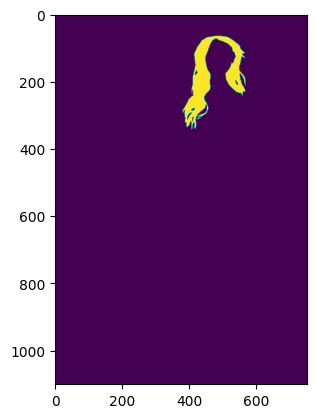

In [77]:
plt.imshow(x['segm']==13)

uint8
torch.uint8


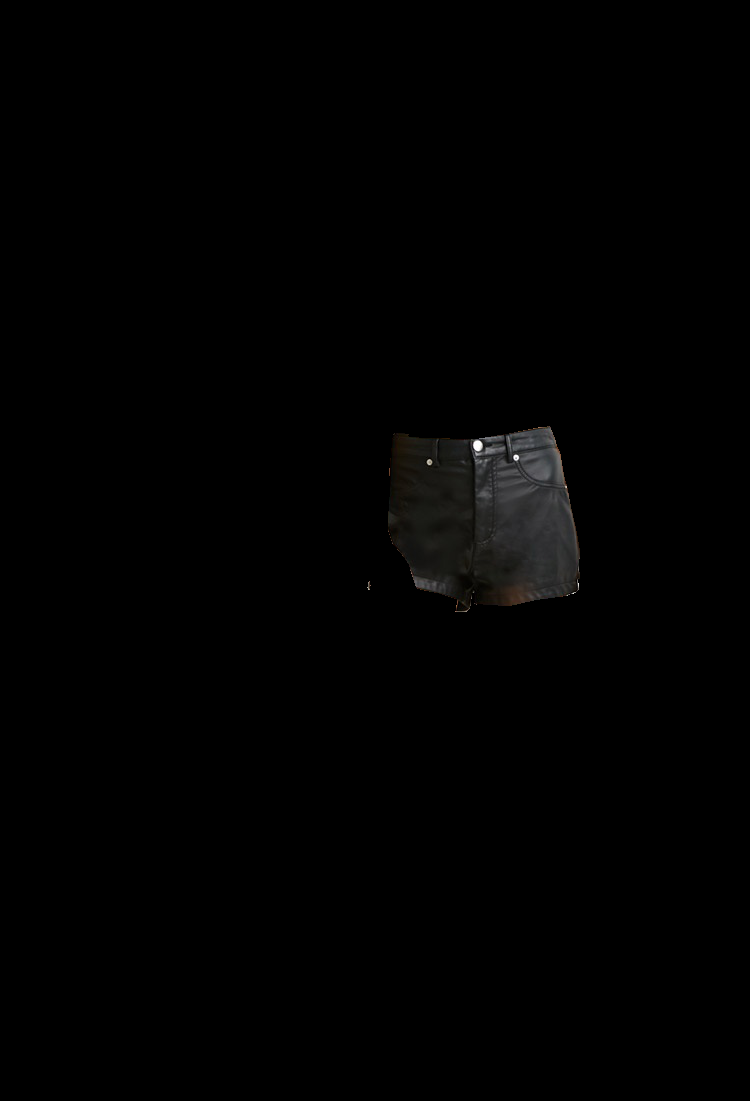

In [123]:
def get_mask(image, segm, mask_ids):
    print(segm.dtype)
    segm = torch.from_numpy(segm)
    print(segm.dtype)
    image = T.ToTensor()(image)    
    mask = torch.zeros_like(segm)
    for mask_id in mask_ids:
        mask |= segm== mask_id    
    return mask * image

segment = get_mask(x['image'], x['segm'], [3, 4, 6, 5])
T.ToPILImage()(segment)

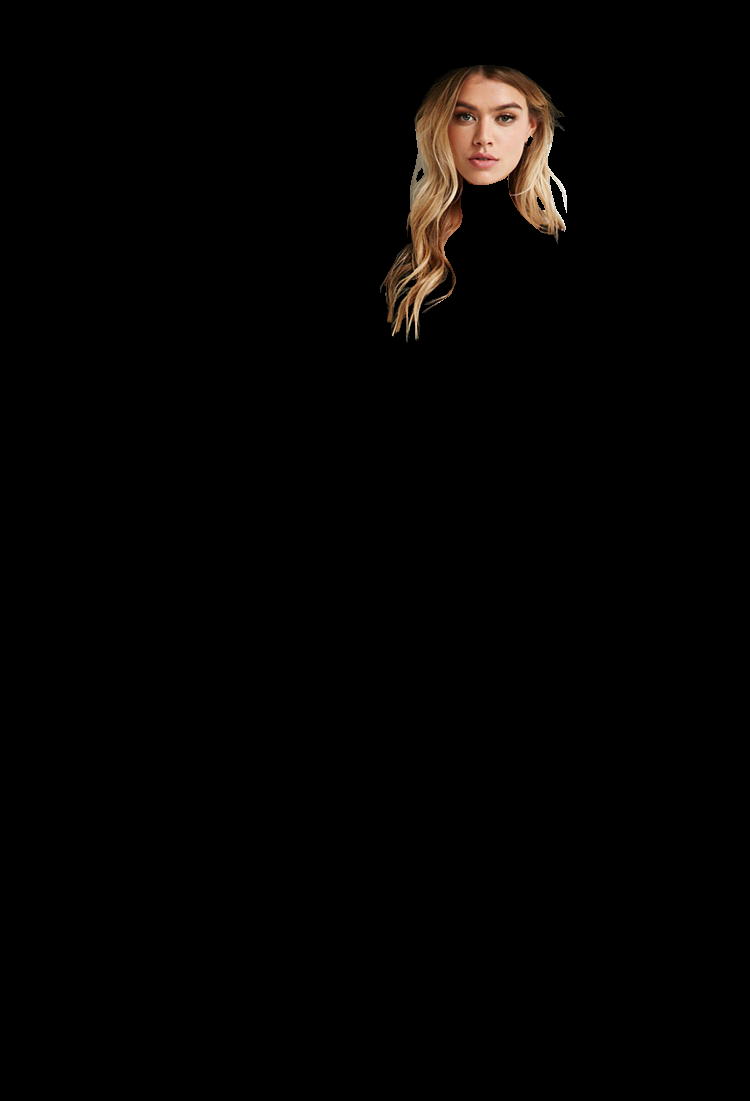

In [44]:
print(x['txt'])

This lady wears a short-sleeve T-shirt with stripe patterns. The T-shirt is with cotton fabric. It has a crew neckline. The shorts this lady wears is of three-point length. The shorts are with leather fabric and solid color patterns. The lady is wearing a hat.


In [ ]:
class DeepFashionMM(Loader):

    def __init__(self, pickle_file, folder, 
                smpl_folder, face_folder=None, is_train=True, shuffle=False, \
                random_drop=0.0, test_size=0.005, test_split_random=None,
                random_face=None):
        super().__init__(pickle_file, folder, shuffle)
        self.random_drop = random_drop  # drop smpl condition 
        self.random_face = random_face
        self.smpl_folder = smpl_folder
        self.face_folder = face_folder
        self.use_face = face_folder != None
        self.df['num_keypoints']=self.df.keypoints.map(lambda x: x.shape[0])
        self.df = self.df[self.df['num_keypoints']==1] 

        train, test = train_test_split(self.df, test_size=test_size, random_state=test_split_random)
        self.df = train if is_train else test

        self.image_dir = folder
        self.image_transform = T.Compose([
            #T.Resize((512,512)),
            T.ToTensor(),
            T.Lambda(lambda x: rearrange(x * 2. - 1., 'c h w -> h w c'))])
            #T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])

    def __getitem__(self, ind):
        try:
            sample = self.df.iloc[ind]
            image_file = os.path.join(self.image_dir, sample.image)
            image = PIL.Image.open(image_file)
            image = image.convert('RGB') if image.mode != 'RGB' else image
            # FIXME
            image = image.resize((384,512))
            #image = np.array(image)[:,32:-32,:]

            image = self.image_transform(image)

            smpl_image_file = os.path.join(self.smpl_folder, sample.image)
            smpl_file = smpl_image_file.replace('.jpg','.p')

            smpl_image = PIL.Image.open(smpl_image_file)
            #smpl_image = smpl_image.convert('RGB') if smpl_image.mode != 'RGB' else smpl_image
            smpl_image = self.image_transform(smpl_image)

            with open(smpl_file, 'rb') as f:
                smpl_params = pickle.load(f)
                pred_pose = smpl_params[0]['pred_body_pose']
                pred_betas = smpl_params[0]['pred_betas']
                pred_camera = np.expand_dims(smpl_params[0]['pred_camera'], 0)
                smpl_pose = np.concatenate((pred_pose, pred_betas, pred_camera), axis=1)
                smpl_pose = T.ToTensor()(smpl_pose).view((1,-1))

            if self.use_face:
                face_file = image_file.replace(self.image_dir, self.face_folder)
                face_folder = os.path.dirname(face_file)
                face_files = glob(os.path.join(face_folder,'*.jpg'))

                if self.random_face == 'front':
                    front_faces = [x for x in face_files if self.random_face in x]
                    if len(front_faces) > 0:
                        face_file = front_faces[0]

                elif self.random_face == True:
                    face_file = random.choice(face_files)

                face_embed_file = face_file.replace('.jpg', '.p')

                face_image = PIL.Image.open(face_file)
                #face_image = T.Resize((64,64))(face_image)
                face_image = self.image_transform(face_image)
                with open(face_embed_file, 'rb') as f:
                    face_embed = pickle.load(f)
                    face_embed = T.ToTensor()(np.expand_dims(face_embed, 0)).view((1,-1))
                
        except Exception as e:
            #print(e)
            #print(f"An exception occurred trying to load SMPL or Face embedding.")
            #print(f"Skipping index {ind}")
            return self.skip_sample(ind)

        descriptions = sample.text.copy()
        keypoints = sample.keypoints.copy()
        keypoints = T.ToTensor()(keypoints).view((1,-1))
        descriptions = list(filter(lambda t: len(t) > 0, descriptions))
        try:
            description = choice(descriptions)
        except IndexError as zero_captions_in_file_ex:
            print(f"An exception occurred trying to load captions.")
            print(f"Skipping index {ind}")
            return self.skip_sample(ind)

        if self.random_drop > 0 and np.random.uniform() < self.random_drop:
            smpl_image = torch.zeros_like(smpl_image)
            smpl_pose = torch.zeros_like(smpl_pose)


        return_d = {"image": image, "txt": description, 'smpl':smpl_pose, 'smpl_image':smpl_image}

        if self.use_face:
            if self.random_drop > 0 and np.random.uniform() < self.random_drop:
                face_image = torch.zeros_like(face_image)
                face_embed = torch.zeros_like(face_embed)

            return_d["face_image"] = face_image
            return_d['face_embed'] = face_embed

        return return_d